<a href="https://colab.research.google.com/github/Fakhre-Alam-Hub/Leaf-Disease-Segmentation/blob/main/Image_segmentation_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Leaf Disease Segmentation

## Import required libraries

In [ ]:
!pip install segmentation_models

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd 
from sklearn.model_selection import train_test_split 

## Dataset Preparation

In [ ]:
pd.set_option('max_colwidth', 400)

img_ids = []
img_path = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        img_path.append(path)
        
        img_id = filename.split(".")[0]
        img_ids.append(img_id)

d = {"id": img_ids, "img_path": img_path}
img_df = pd.DataFrame(data = d)
img_df = img_df.set_index('id')

mask_ids = []
mask_path = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        mask_id = filename.split(".")[0]
        mask_ids.append(mask_id)

        
d = {"id": mask_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')

In [ ]:
df = pd.merge(img_df, mask_df, on = "id", how = "inner")
df = df.sort_index()
df.head()

img_path                                                                    mask_path
id                                                                                                                                                                
00000_0  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images/00000_0.jpg  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks/00000_0.png
00000_1  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images/00000_1.jpg  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks/00000_1.png
00000_2  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images/00000_2.jpg  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks/00000_2.png
00000_3  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images/00000_3.jpg  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks/00000_3.png
00000_4  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images/00000_4.jpg  /content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks/00000_4.png

In [ ]:
df.shape

(2940, 2)

In [ ]:
%cd /content/drive/MyDrive/Leaf Disease Segmentation

/content/drive/MyDrive/Leaf Disease Segmentation


In [ ]:
from unet import unet_model
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score

TRAIN_LENGTH = len(train_image_paths)
TEST_LENGTH = len(test_image_paths)
BATCH_SIZE = 4
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE

# creating object of unet architecture
model = unet_model()

# compile model
model.compile(optimizer='adam',
              loss = bce_jaccard_loss,
              metrics=[iou_score])

EPOCHS = 3

# fit model
model_history = model.fit(train_batches, epochs = 3,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_data = test_batches,
                          validation_steps = VALIDATION_STEPS,
                          )

Epoch 1/3
6/6 [==============================] - 22s 4s/step - loss: 1.5703 - iou_score: 0.0972 - val_loss: 1.3915 - val_iou_score: 0.0343
Epoch 2/3
6/6 [==============================] - 18s 3s/step - loss: 1.4835 - iou_score: 0.1044 - val_loss: 1.3385 - val_iou_score: 0.0404
Epoch 3/3
6/6 [==============================] - 18s 3s/step - loss: 1.4639 - iou_score: 0.0995 - val_loss: 1.3131 - val_iou_score: 0.0381


## Preprocessing Pipeline

In [ ]:
def preprocess(img_path, mask_path, img_size = (256,256)):
    input_image = tf.io.read_file(img_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    input_image = tf.image.resize(input_image, img_size) 
    input_image = tf.cast(input_image, tf.float32) / 255.0

    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_jpeg(input_mask, channels=1)
    input_mask = tf.image.resize(input_mask, img_size)
    input_mask = tf.math.sign(input_mask)

    return input_image, input_mask

def create_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((sorted(df["img_path"].values), sorted(df["mask_path"].values)))
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    return ds

In [ ]:
train_df, test_df = train_test_split(df, random_state=42, test_size=.10)
train_images = create_dataset(train_df)
test_images = create_dataset(test_df)

## Generating Batches

In [ ]:
TRAIN_LENGTH = len(train_df)
TEST_LENGTH = len(test_df)
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

## Dispaly data

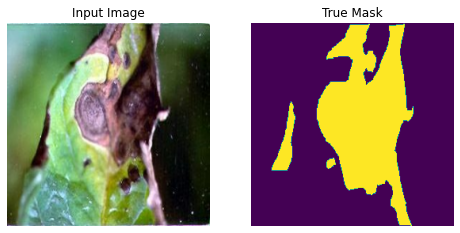

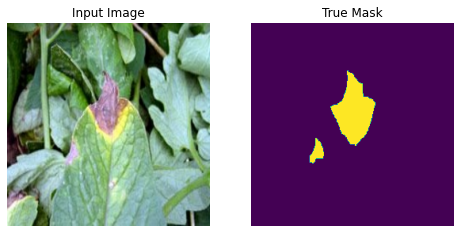

In [ ]:
def display(display_list):
  plt.figure(figsize=(8, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Model preparation and training

In [ ]:
%cd /content/drive/MyDrive/Leaf Disease Segmentation

/content/drive/MyDrive/Leaf Disease Segmentation


In [ ]:
from unet import unet_model
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score

# creating object of unet architecture
model = unet_model()

# compile model
model.compile(optimizer='adam',
              loss = bce_jaccard_loss,
              metrics=[iou_score])

Segmentation Models: using `keras` framework.


In [ ]:
# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
        patience=50, monitor='val_iou_score',
        mode='max', restore_best_weights=True
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='model/model_disease3.h5', monitor='val_iou_score',
        verbose=0, save_best_only=True, mode='max'
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_iou_score', factor=0.1, patience=5, verbose=0,
        mode='max', min_delta=0.0001, min_lr=0.00002,
    )

tb_callback = tf.keras.callbacks.TensorBoard('model/logs3/logs')
            
EPOCHS = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# fit model
model_history = model.fit(train_batches, epochs = EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_data = test_batches,
                          validation_steps = VALIDATION_STEPS,
                          callbacks=[early_stop, reduce_lr, checkpoint, tb_callback])

Epoch 1/2000
82/82 [==============================] - 737s 9s/step - loss: 1.2635 - iou_score: 0.1638 - val_loss: 1.1397 - val_iou_score: 0.2123
Epoch 2/2000
82/82 [==============================] - 34s 375ms/step - loss: 1.0631 - iou_score: 0.2885 - val_loss: 0.9977 - val_iou_score: 0.3202
Epoch 3/2000
82/82 [==============================] - 30s 370ms/step - loss: 0.9830 - iou_score: 0.3478 - val_loss: 0.9642 - val_iou_score: 0.3523
Epoch 4/2000
82/82 [==============================] - 31s 377ms/step - loss: 0.9578 - iou_score: 0.3617 - val_loss: 0.9681 - val_iou_score: 0.3614
Epoch 5/2000
82/82 [==============================] - 30s 371ms/step - loss: 0.9456 - iou_score: 0.3704 - val_loss: 0.9823 - val_iou_score: 0.3717
Epoch 6/2000
82/82 [==============================] - 31s 372ms/step - loss: 0.9360 - iou_score: 0.3758 - val_loss: 0.9354 - val_iou_score: 0.3705
Epoch 7/2000
82/82 [==============================] - 31s 373ms/step - loss: 0.9046 - iou_score: 0.3961 - val_loss: 0.91

In [ ]:
import datetime;
  
ct = datetime.datetime.now()
print("current time:-", ct)

current time:- 2021-08-13 18:30:26.498147


In [ ]:
import tensorflow as tf

path = '/content/drive/MyDrive/Leaf Disease Segmentation/model/model_disease2.h5'
new_model = tf.keras.models.load_model(path,compile=False)

In [ ]:
#plot the training and validation score and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

score = model_history.history['iou_score']
val_score = model_history.history['val_iou_score']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()

plt.subplot(122)
plt.plot(epochs, score, 'r', label='Training score')
plt.plot(epochs, val_score, 'g', label='Validation score')
plt.title('Training and validation score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

## Prediction on image

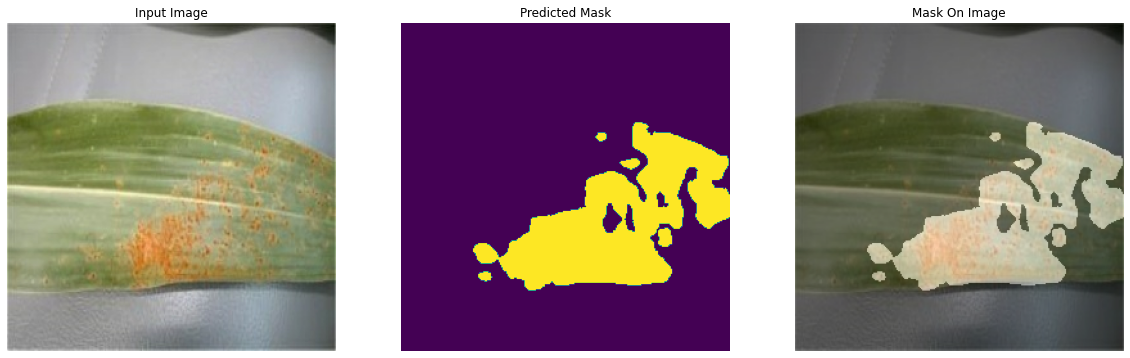

In [ ]:
import cv2
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def predict(img_path, model, img_size = (256,256)):
    input_image = tf.io.read_file(img_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    input_image = tf.image.resize(input_image, img_size) 
    input_image = tf.cast(input_image, tf.float32) / 255.0
    pred_mask = (model.predict(input_image[tf.newaxis, ...])[0,:,:,0] > 0.5).astype(np.uint8)
    pred_mask = pred_mask.reshape(img_size[0], img_size[1], 1)

    mask = np.zeros_like(input_image.numpy())
    mask[:,:,0] = pred_mask[:,:,0]
    mask[:,:,1] = pred_mask[:,:,0]
    mask[:,:,2] = pred_mask[:,:,0]

    alpha = 0.6
    beta = (1.0 - alpha)
    mask_on_img = cv2.addWeighted(input_image.numpy(), alpha, mask, beta, 0.0)

    display([input_image, pred_mask, mask_on_img])

    return input_image, pred_mask, mask_on_img

img_path = '/content/drive/MyDrive/Leaf Disease Segmentation/data/images/00456.jpg'
input_image, pred_mask, mask_on_img = predict(img_path, model = new_model)

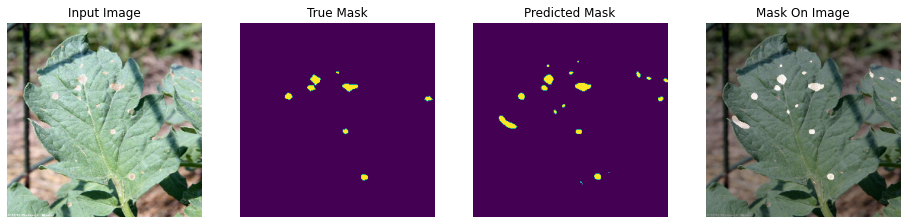

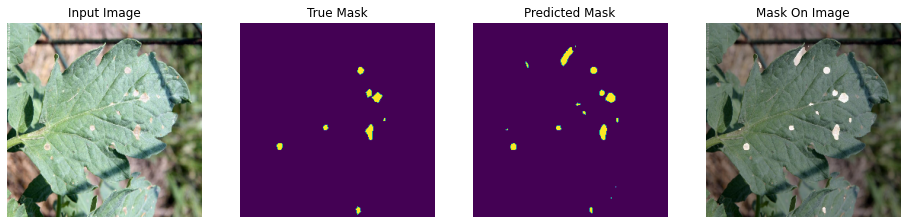

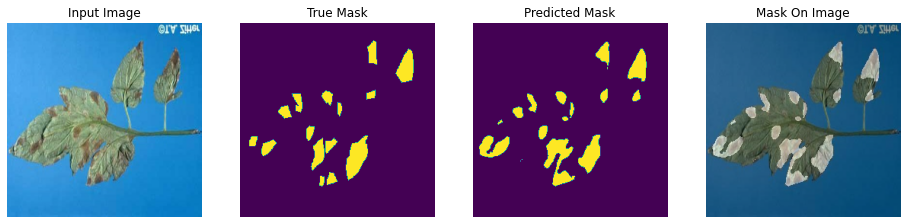

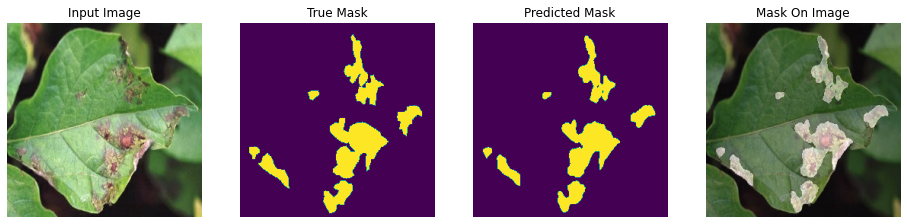

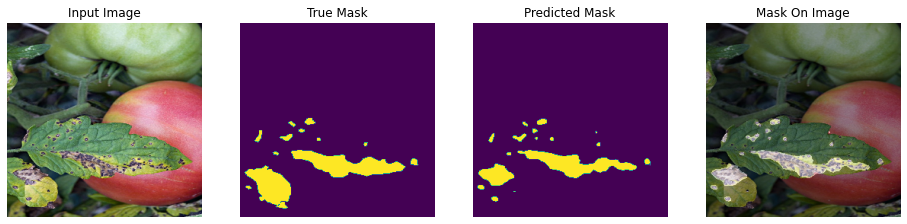

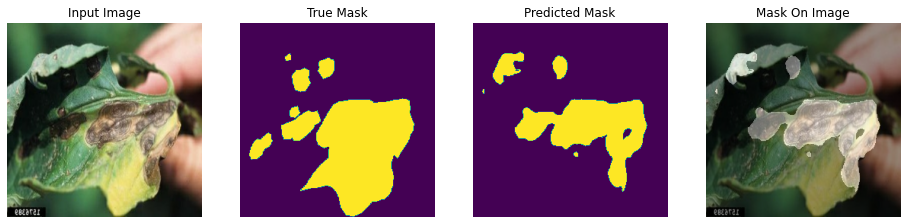

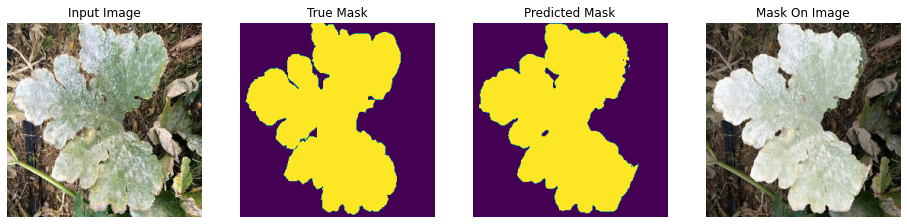

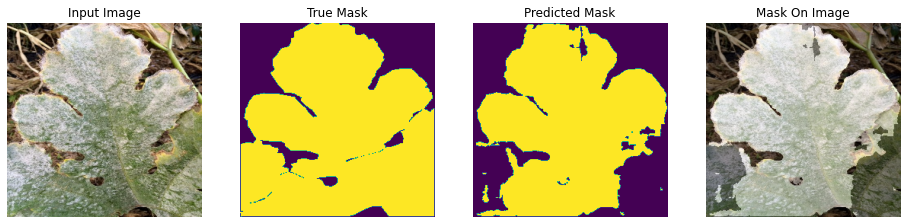

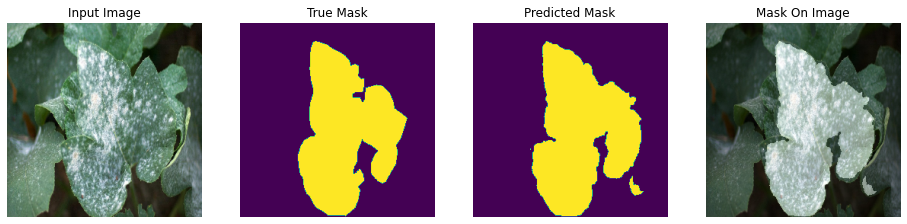

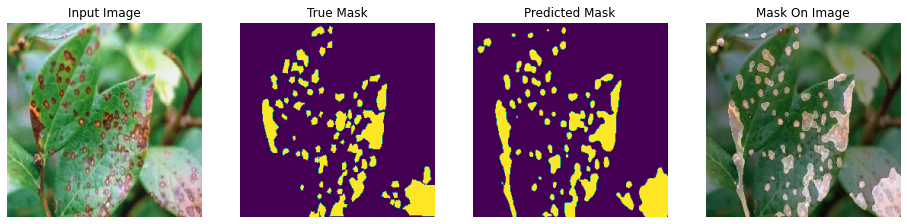

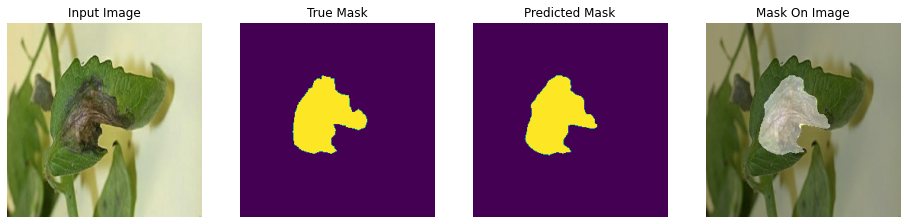

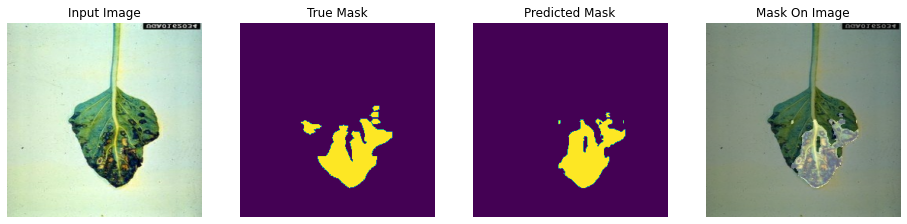

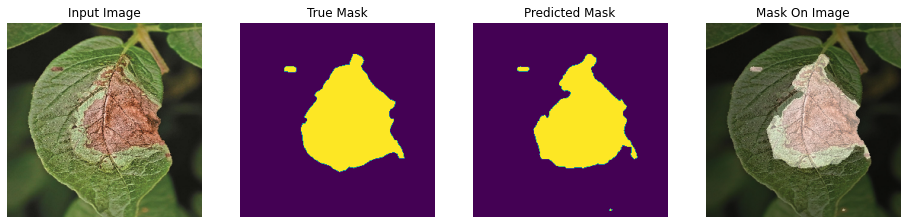

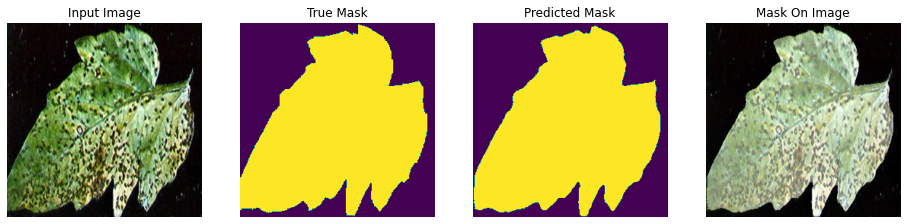

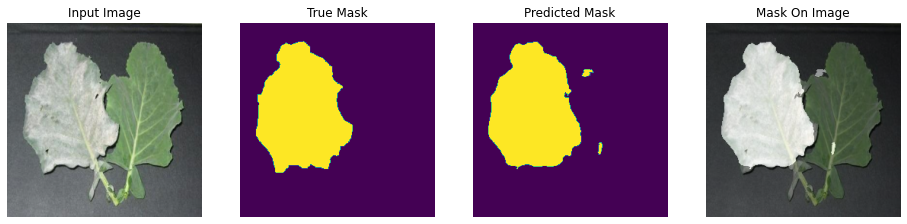

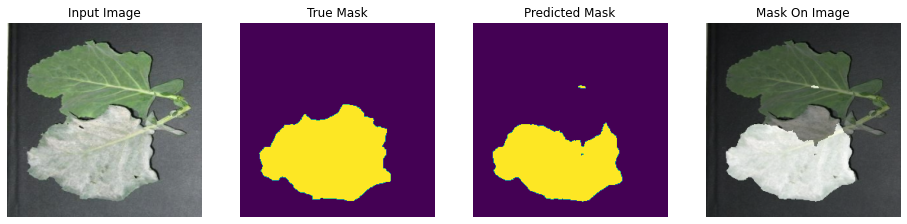

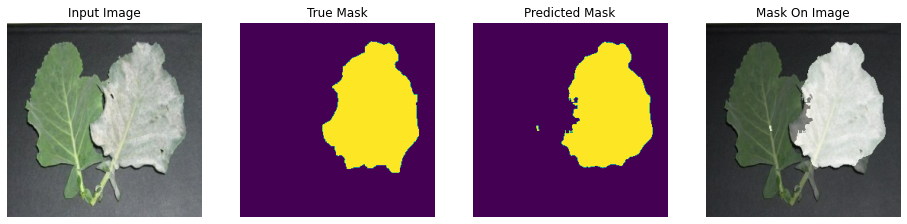

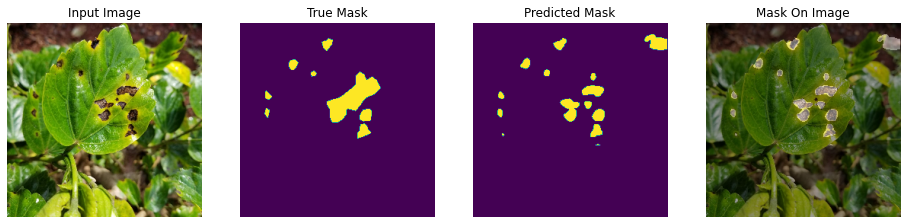

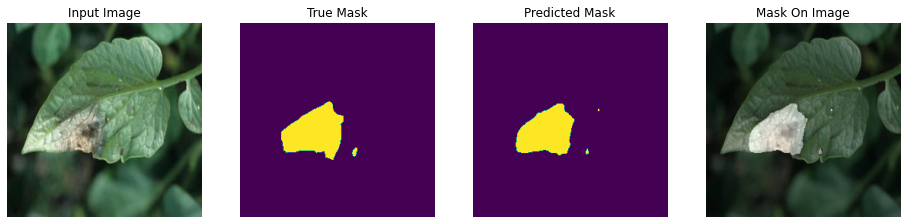

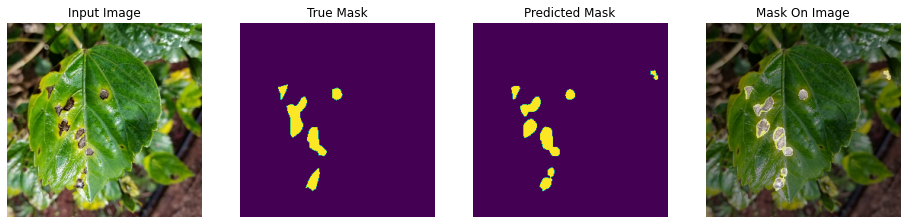

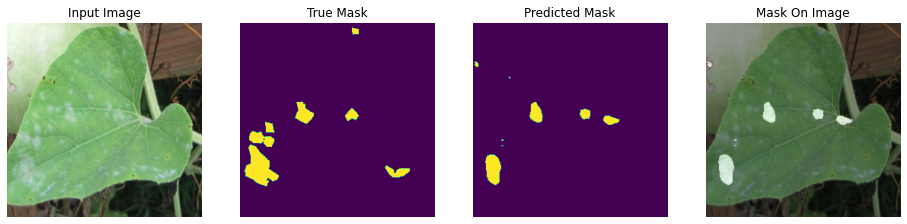

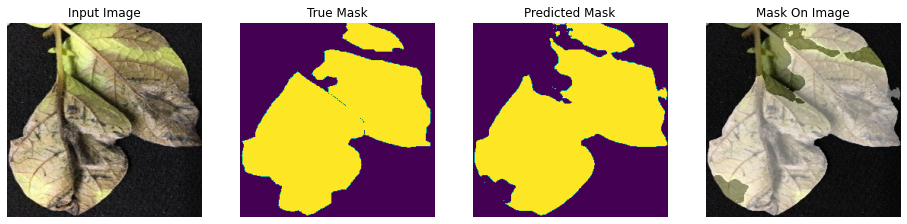

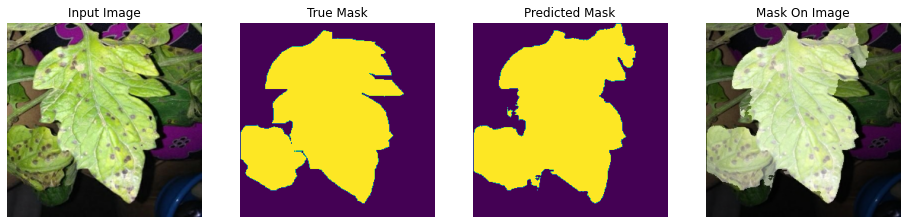

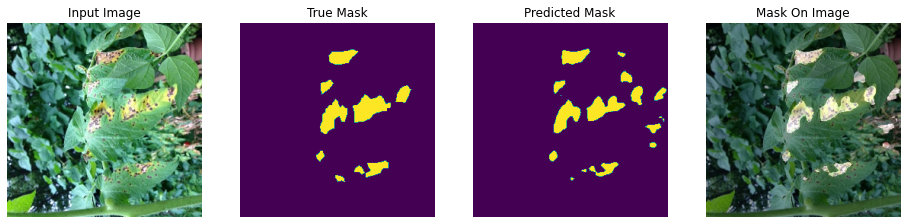

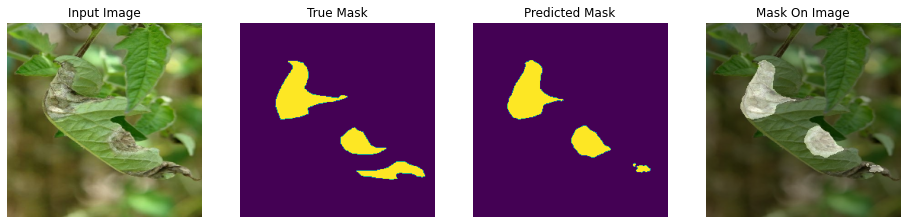

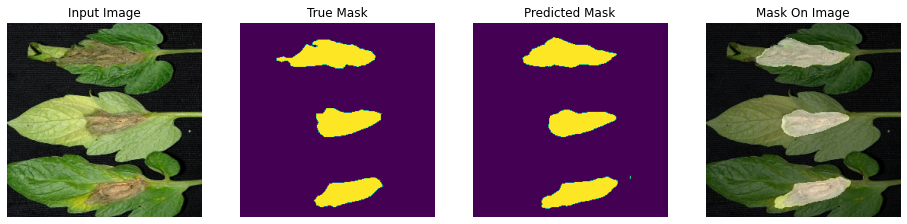

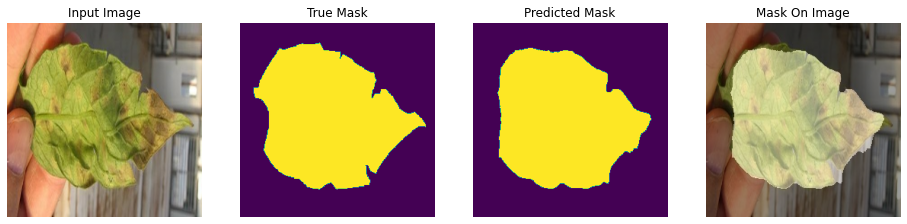

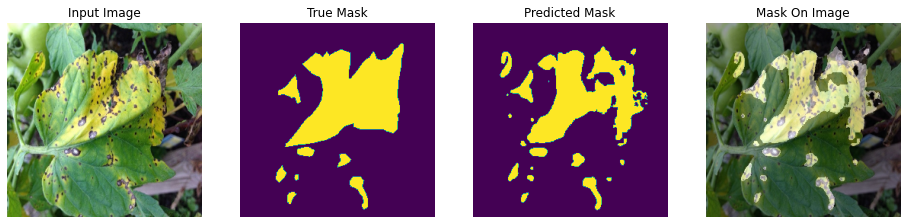

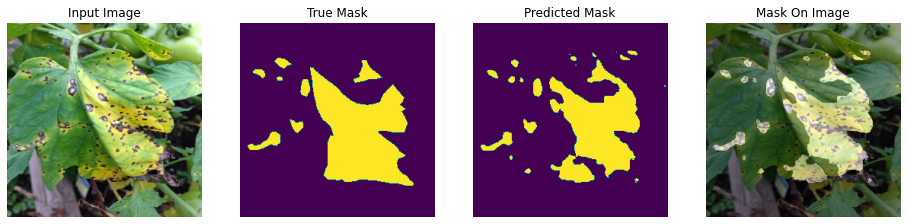

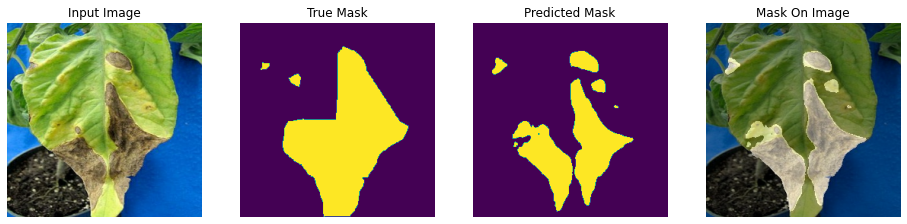

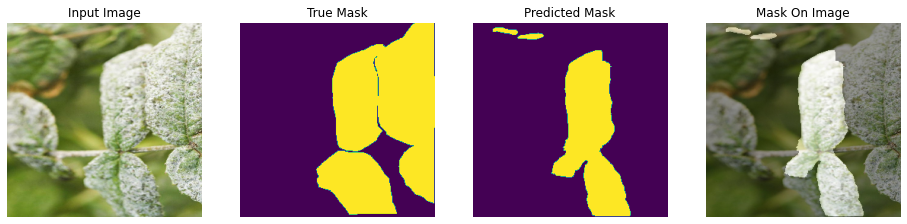

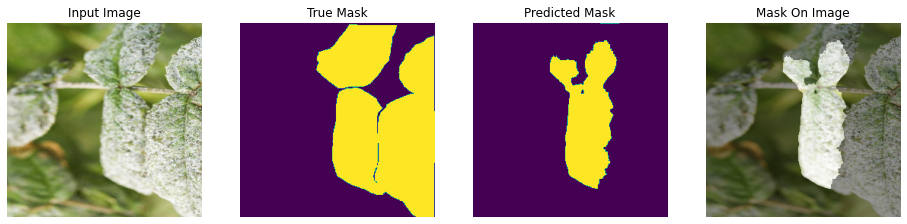

In [ ]:
def display(display_list):
  plt.figure(figsize=(16, 16))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

img_size=[256,256]
for images, masks in test_batches.take(1):
    batch_images, batch_masks = images.numpy(), masks.numpy()
    for image, true_mask in zip(batch_images, batch_masks):
        pred_mask = (new_model.predict(image[tf.newaxis, ...])[0,:,:,0] > 0.5).astype(np.uint8)
        pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)

        mask = np.zeros_like(image)
        mask[:,:,0] = pred_mask[:,:,0]
        mask[:,:,1] = pred_mask[:,:,0]
        mask[:,:,2] = pred_mask[:,:,0]

        alpha = 0.6
        beta = (1.0 - alpha)
        mask_on_img = cv2.addWeighted(image, alpha, mask, beta, 0.0)

        display([image, true_mask, pred_mask, mask_on_img])

## Clipping Image Using Mask

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

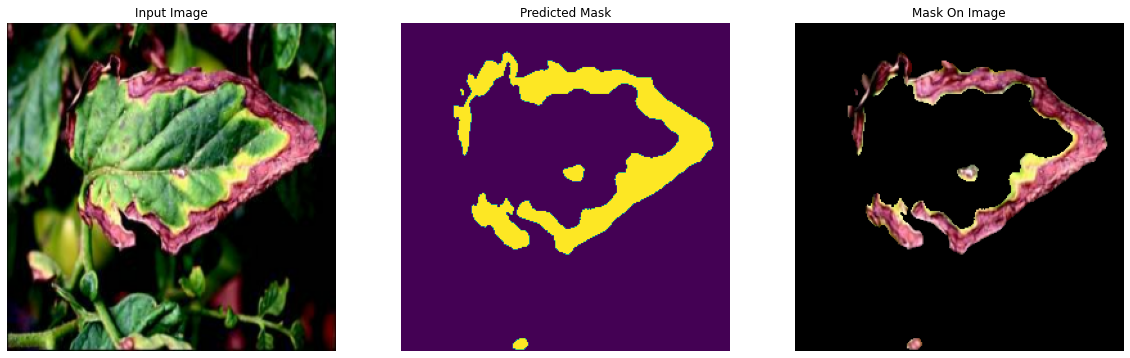

In [ ]:
# import cv2
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def predict(img_path, model, img_size = (256,256)):
    input_image = tf.io.read_file(img_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    input_image = tf.image.resize(input_image, img_size) 
    input_image = tf.cast(input_image, tf.float32) / 255.0
    pred_mask = (model.predict(input_image[tf.newaxis, ...])[0,:,:,0] > 0.5).astype(np.uint8)
    pred_mask = pred_mask.reshape(img_size[0], img_size[1], 1)

    mask_on_img = cv2.add(input_image.numpy(),  np.zeros(np.shape(img), dtype= np.uint8),
                          mask = pred_mask, dtype=cv2.CV_64F)

    display([input_image, pred_mask, mask_on_img])

    return input_image, pred_mask, mask_on_img

img_path = '/content/drive/MyDrive/Leaf Disease Segmentation/data/images/00001.jpg'
input_image, pred_mask, mask_on_img = predict(img_path, model = new_model)

In [ ]:
mask_on_img.dtype

dtype('float64')

In [ ]:
img_path = '/content/drive/MyDrive/Leaf Disease Segmentation/data/images/00004.jpg'
mask_path = '/content/drive/MyDrive/Leaf Disease Segmentation/data/masks/00004.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

masked = cv2.add(img,  np.zeros(np.shape(img), dtype= np.uint8), mask = mask)
img.shape, mask.shape, masked.shape

((256, 256, 3), (256, 256), (256, 256, 3))

In [ ]:
np.unique(mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=uint8)

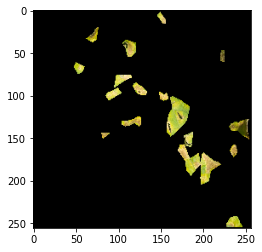

In [ ]:
plt.imshow(masked)

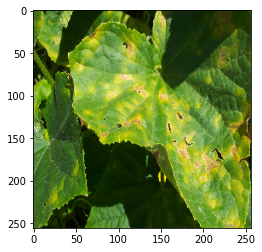

In [ ]:
plt.imshow(img)

In [ ]:
input_image.shape, pred_mask.shape, mask_on_img.shape

(TensorShape([256, 256, 3]), (256, 256, 1), (256, 256, 3))

## Augment and predict

In [ ]:
import albumentations as A

aug = A.HorizontalFlip(p=1)
img_path = '/content/drive/MyDrive/Leaf Disease Segmentation/data/images/00001.jpg'
img_size = (256,256)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, img_size)
image = image / 255.0

augmented = aug(image=image)

image_h_flipped = augmented['image']

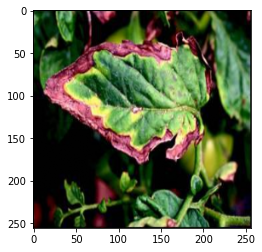

In [ ]:
plt.imshow(image_h_flipped)

In [ ]:
pred = (new_model.predict(image_h_flipped[np.newaxis, ...])[0,:,:,0] > 0.5).astype(np.uint8)
pred = pred.reshape(256, 256, 1)

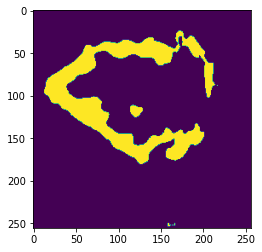

In [ ]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred))

# Just checking

In [ ]:
IMAGE_DIR_PATH = '/content/drive/MyDrive/Leaf Disease Segmentation/aug_data/images'
MASK_DIR_PATH = '/content/drive/MyDrive/Leaf Disease Segmentation/aug_data/masks'

image_paths = [os.path.join(IMAGE_DIR_PATH, x) for x in sorted(os.listdir(IMAGE_DIR_PATH))]
mask_paths = [os.path.join(MASK_DIR_PATH, x) for x in sorted(os.listdir(MASK_DIR_PATH))]

train_image_paths =  image_paths[:24]
test_image_paths =  image_paths[24:34]

train_mask_paths = mask_paths[:24]
test_mask_paths = mask_paths[24:34]

import random
AUTOTUNE = tf.data.AUTOTUNE

class DataLoader:
    """A TensorFlow Dataset API based loader for semantic segmentation problems."""

    def __init__(self, image_paths, mask_paths, image_size,
                 channels = (3, 1), seed = None):
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.channels = channels
        self.seed = seed

    def preprocess(self, img_path, mask_path):
        input_image = tf.io.read_file(img_path)
        input_image = tf.image.decode_jpeg(input_image, channels=3)
        input_image = tf.image.resize(input_image, self.image_size) 
        input_image = tf.cast(input_image, tf.float32) / 255.0

        input_mask = tf.io.read_file(mask_path)
        input_mask = tf.image.decode_jpeg(input_mask, channels=1)
        input_mask = tf.image.resize(input_mask, self.image_size)
        input_mask = tf.math.sign(input_mask)

        return input_image, input_mask

    def data_batch(self, batch_size, shuffle=False):
        data = tf.data.Dataset.from_tensor_slices((self.image_paths, self.mask_paths))
        data = data.map(self.preprocess, num_parallel_calls=AUTOTUNE)

        if shuffle:
            # Prefetch, shuffle then batch
            data = data.prefetch(AUTOTUNE).shuffle(random.randint(0, len(self.image_paths))).batch(batch_size)
        else:
            # Batch and prefetch
            data = data.batch(batch_size).prefetch(AUTOTUNE)
        return data

BATCH_SIZE = 4
train_dataset = DataLoader(image_paths=train_image_paths,
                     mask_paths=train_mask_paths,
                     image_size=(256, 256),
                     seed=47)

test_dataset = DataLoader(image_paths=test_image_paths,
                     mask_paths=test_mask_paths,
                     image_size=(256, 256),
                     seed=47)

# Parse the images and masks, and return the data in batches.
train_batches = train_dataset.data_batch(batch_size=BATCH_SIZE,
                             shuffle=True)

test_batches = test_dataset.data_batch(batch_size=BATCH_SIZE,
                             shuffle=True)